# Delta-vega, delta-gamma и delta-vega-gamma хеджирование

В данном ноутбуке рассмотрим хеджирование опционов на базовый актив AAPL.O, данные были получены через refiniv, код получения и обработки данных в ```refinitiv_datafetching.ipynb```

In [1]:
import pandas as pd
from pyfinance.options import BSM
from datetime import datetime, timedelta
import py_vollib
from py_vollib.black_scholes.implied_volatility import implied_volatility
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("..data/aapl.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df['date'] = pd.to_datetime(df['Date'])
df['T'] = (pd.to_datetime('2024-11-06') - df['date']).dt.days / 252 # T = time to expiration in years, 252 trading days
df = df.drop(["date"], axis=1)
df.head()

#interest rate data
df2 = pd.read_csv('../data/daily-treasury-rates.csv')
df2 = df2[['Date', '13 WEEKS COUPON EQUIVALENT']]
df2['Date'] = pd.to_datetime(df2['Date'], format='%m/%d/%Y')
df2['Date'] = df2['Date'].dt.strftime('%Y-%m-%d')
df2 = df2[df2['Date'] >= '2023-08-21']
df2['13 WEEKS COUPON EQUIVALENT'] = df2['13 WEEKS COUPON EQUIVALENT'] / 100
df_result = pd.merge(df, df2, on='Date', how='left')
df_result.rename({"13 WEEKS COUPON EQUIVALENT": "Interest rate"}, axis="columns", inplace=True)
df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)
df_result.head()

/var/folders/5l/g4vstt3n6vbfy2mn99vrps100000gn/T/ipykernel_3203/3781373455.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_result['Interest rate'].fillna(df_result['Interest rate'].median(), inplace=True)


,Date,Underlying,C215,C220,C225,C230,C235,P215,P220,P225,P230,P235,T,Interest rate
0,2024-10-10,229.04,18.05,14.41,11.23,8.65,5.80,3.30,4.67,6.40,8.35,10.25,0.107143,0.0466
1,2024-10-11,227.55,17.89,14.10,10.95,7.55,5.46,3.06,4.35,5.95,8.50,10.80,0.103175,0.0464
2,2024-10-14,231.30,19.50,16.00,12.50,9.27,6.70,2.46,3.42,4.84,6.60,9.00,0.091270,0.0463
3,2024-10-15,233.85,22.53,19.50,14.05,10.62,7.83,2.19,3.07,4.20,5.90,8.07,0.087302,0.0464
4,2024-10-16,231.78,18.75,15.18,12.04,9.21,6.47,2.16,3.23,4.53,6.70,8.74,0.083333,0.0463


In [21]:
def get_greeks_for_option(option, call_vola, put_vola, call_strike, put_strike):
    call_bsm = BSM(kind='call', S0=option['Underlying'], K=call_strike, T=option['T'], r=option['Interest rate'], sigma=call_vola)
    put_bsm = BSM(kind='put', S0=option['Underlying'], K=put_strike, T=option['T'], r=option['Interest rate'], sigma=put_vola)
    return call_bsm.delta(), call_bsm.gamma(), call_bsm.vega(), put_bsm.delta(), put_bsm.gamma(), put_bsm.vega()
    

In [22]:
def plot_volatilities(data):
    df = data
    df.reset_index(drop=True, inplace=True)
    hedged_dates = df[df['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_volatility'], label='Call Volatility', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_volatility'], label='Put Volatility', marker='o')
    
    # Customize the plot
    plt.title('Implied volatility of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Implied volatility')
    plt.legend()
    plt.grid(True)
    plt.show()

In [23]:
def plot_deltas(data):
    df = data
    df.reset_index(inplace=True)
    hedged_dates = df[df['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_delta'], label='Call Delta', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_delta'], label='Put Delta', marker='o')
    
    # Customize the plot
    plt.title('Delta of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Delta')
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
def plot_gammas(data):
    df = data
    df.reset_index(inplace=True)
    hedged_dates = df[df['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_gamma'], label='Call Gamma', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_gamma'], label='Put Gamma', marker='o')
    
    # Customize the plot
    plt.title('Gamma of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Gamma')
    plt.legend()
    plt.grid(True)
    plt.show()

In [25]:
def plot_vegas(data):
    df = data
    df.reset_index(inplace=True)
    hedged_dates = df[df['rehedging']]
    plt.figure(figsize=(10, 6))
    plt.plot(hedged_dates['Date'], hedged_dates['call_vega'], label='Call Vega', marker='o')
    plt.plot(hedged_dates['Date'], hedged_dates['put_vega'], label='Put Vega', marker='o')
    
    # Customize the plot
    plt.title('Vega of Call and Put Options Over Time')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Vega')
    plt.legend()
    plt.grid(True)
    plt.show()

In [69]:
def plot_total_error_with_frequencies():
    hedging_frequencies = [1, 2, 5, 10, 30]
    
    results_dict = {'Frequency': [], 'Total_MSE': []}
    
    for freq in hedging_frequencies:
        total_mean_squared_error, total_error, portfolio_values, OPs, REs, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C225", "P225")
        results_dict['Frequency'].append(freq)
        results_dict['Total_MSE'].append(total_error)
    
    # Plotting
    plt.plot(results_dict['Frequency'], results_dict['Total_MSE'], marker='o')
    plt.xlabel('Hedging Frequency (days)')
    plt.ylabel('Total Mean Squared Error')
    plt.title('Total Mean Squared Error vs Hedging Frequency')
    plt.show()

In [78]:
def plot_daily_error():
    hedging_frequencies = [1, 10, 30]
    plt.figure(figsize=(10, 6))
    for freq in hedging_frequencies:
        total_mean_squared_error, total_error, portfolio_values, OPs, REs, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C225", "P225")
        plt.plot(total_mean_squared_error, label=f'Hedging Frequency: {freq} days')
        
    plt.xlabel('Days')
    plt.ylabel('Daily Error')
    plt.title('Daily Error vs Hedging Frequency')
    plt.legend()
    plt.show()

In [81]:
def plot_portfolio_value():
    
    costs = [0.00, 0.02, 0.05]
    plt.figure(figsize=(10, 6))
    for c in costs:
        total_mean_squared_error, total_error, portfolio_values, OPs, REs, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C225", "P225", costs=c) #every other day
        plt.plot(portfolio_values, label=f'Transaction costs: ${c*100}k') # change to % once done
    
    plt.xlabel('Days')
    plt.ylabel('Portfolio value')
    plt.title('Portfolio value with transactions costs, hedging every other day')
    plt.legend()
    plt.show()

## Delta-vega-gamma хеджирование

In [82]:
def delta_vega_gamma_hedge(option_data, freq, call_column, put_column, costs = 0):
    
    initial = option_data.iloc[0]
    option_amount = 1000
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')

    # Delta of the underlying stock is 1, Gamma is 0, Vega is 0
    # To make the portfolio Gamma and Vega neutral, we have to take both call and put options
    # Gamma expresses how much hedging will cost in a small time interval
    # If Gamma of the portfolio is positive, we make money by delta hedging and vice versa
    # With both Delta and Gamma hedging, we obtain a portfolio, which is even less sensitive to small price changes of the underlying
    # Need to rebalance the hedge for a Delta and Gamma neutral portfolio occurs less often, which saves trading costs
    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    # Construct portfolio OP
    OP = option_amount * call_option_price + option_amount * put_option_price

    # Construct portfolio RE
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    portfolio_values = [OP + RE]
    transaction_costs = 0
    
    # Constructing a dataframe for option greeks and implied volatilities, which can then be used later for analysis purposes
    column_names = ['call_delta', 'put_delta', 'call_gamma', 'put_gamma', 'call_vega', 'put_vega', 'call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                            'call_vega': call_vega, 'put_vega': put_vega, 'call_volatility': call_volatility, 'put_volatility': put_volatility,
                            'rehedging': False}, index=idx)
    
    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []

    OPs = [OP]
    REs = [RE]
    
    for i in range(1, len(option_data)-1):
        hedge = False
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE

        # In a ideal situation this should be 0 = IMMUNE TO CHANGES
        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        OPs.append(new_OP)
        REs.append(new_RE)
        
        OP = new_OP
        RE = new_RE
        
        
        if i % freq == 0:
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)
            
            all_greeks_coefficients = np.array([
                [call_delta, call_gamma, call_vega],
                [put_delta, put_gamma, put_vega],
                [1, 0, 0]
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta),
                option_amount * (call_gamma + put_gamma),
                option_amount * (call_vega + put_vega)
            ])

            delta_vega_gamma_neutral = np.linalg.solve(all_greeks_coefficients, right_hand_side)

            print("To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: ")
            if delta_vega_gamma_neutral[0] < 0:
                print("Short (sell) this many units of the underlying", round(delta_vega_gamma_neutral[0]))
            else:
                print("Buy this many units of the underlying", round(delta_vega_gamma_neutral[0]))
            if delta_vega_gamma_neutral[1] < 0:
                print("Sell this many Call options: ", round(delta_vega_gamma_neutral[1]))
            else:
                print("Buy this many Call options: ", round(delta_vega_gamma_neutral[1]))
            if delta_vega_gamma_neutral[2] < 0:
                print("Sell this many Put options: ", round(delta_vega_gamma_neutral[2]))
            else:
                print("Buy this many Put options: ", round(delta_vega_gamma_neutral[2]))
            print('\n')
            
            hedge = True
            
        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma, 'call_vega': call_vega,
                   'put_vega': put_vega, 'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        new_rows.append(new_row)


    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)
     
    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)
    print('\n')

    portfolio_values -= portfolio_values[0]
    REs -= REs[0]
    OPs -= OPs[0]
    
    return total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 51479
Buy this many Call options:  53430605
Sell this many Put options:  -37096


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48481
Sell this many Call options:  -136042624
Buy this many Put options:  103410


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 43304
Buy this many Call options:  25616734
Sell this many Put options:  -20004


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 37068
Buy this many Call options:  189753903
Sell this many Put options:  -172395


To adjust portfolio to be delta-vega-gamma neutral, you need to bala

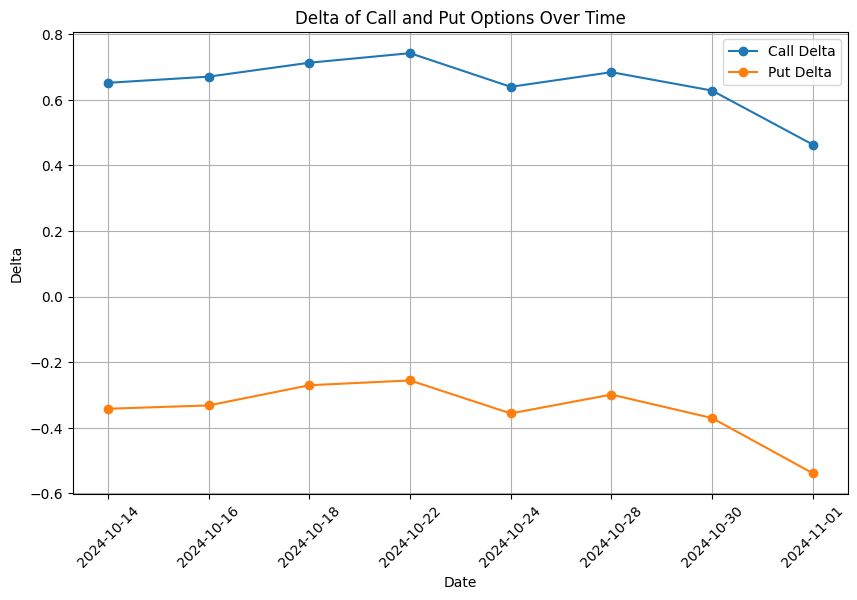

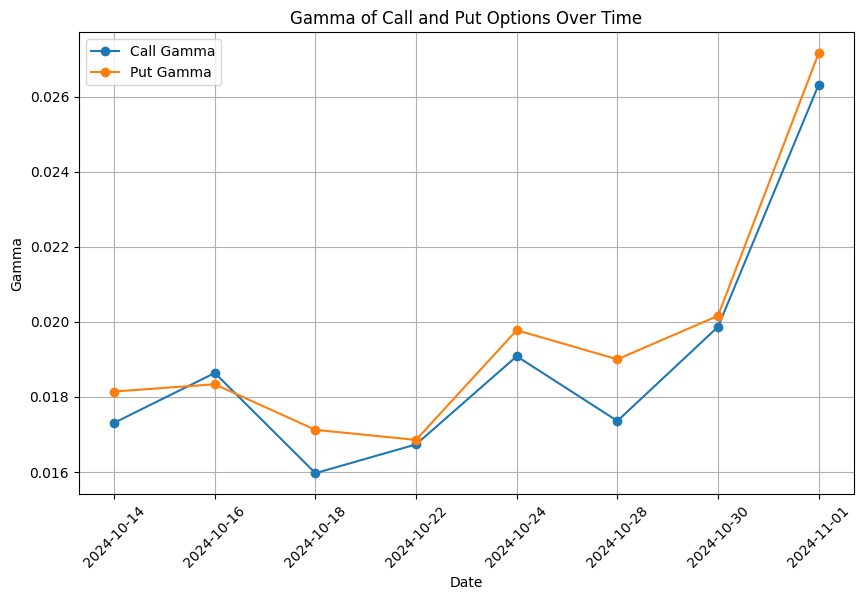

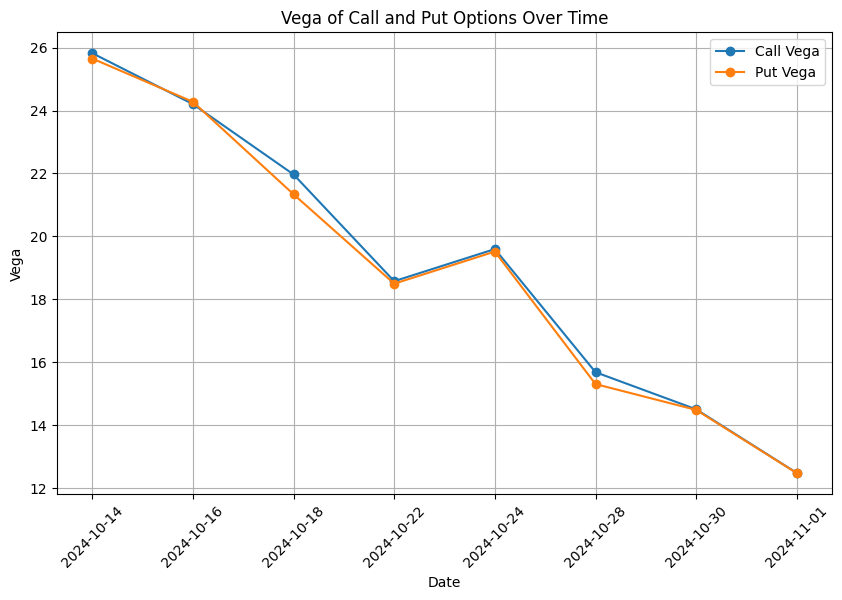

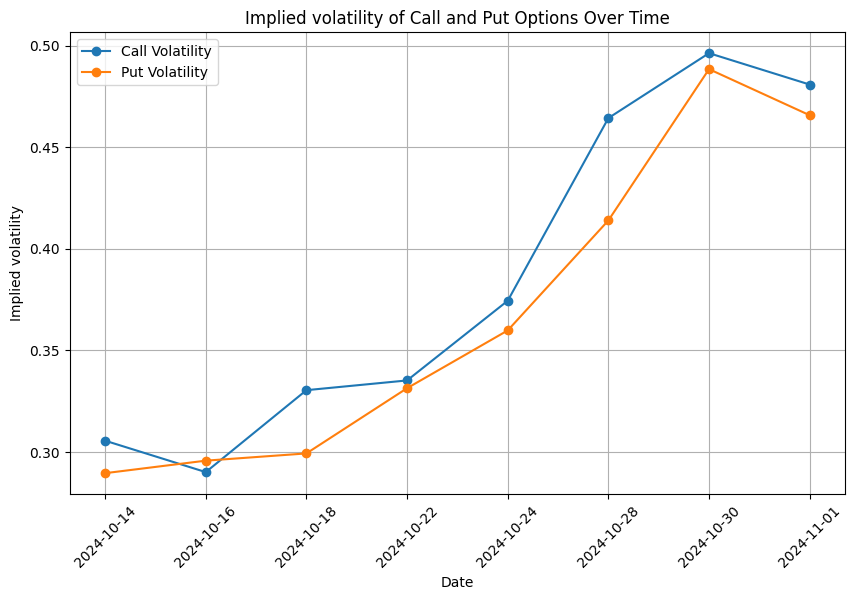

To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 56907
Buy this many Call options:  17986586
Sell this many Put options:  -11948


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 51479
Buy this many Call options:  53430605
Sell this many Put options:  -37096


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48194
Buy this many Call options:  233914537
Sell this many Put options:  -161194


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48481
Sell this many Call options:  -136042624
Buy this many Put options:  103410


To adjust portfolio to be delta-vega-gamma neutral, you need to bala

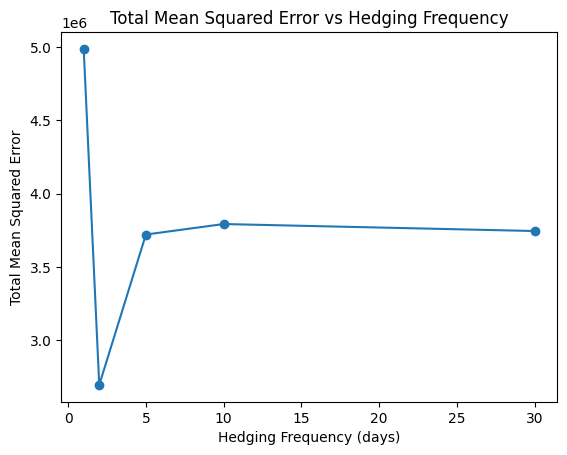

To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 56907
Buy this many Call options:  17986586
Sell this many Put options:  -11948


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 51479
Buy this many Call options:  53430605
Sell this many Put options:  -37096


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48194
Buy this many Call options:  233914537
Sell this many Put options:  -161194


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48481
Sell this many Call options:  -136042624
Buy this many Put options:  103410


To adjust portfolio to be delta-vega-gamma neutral, you need to bala

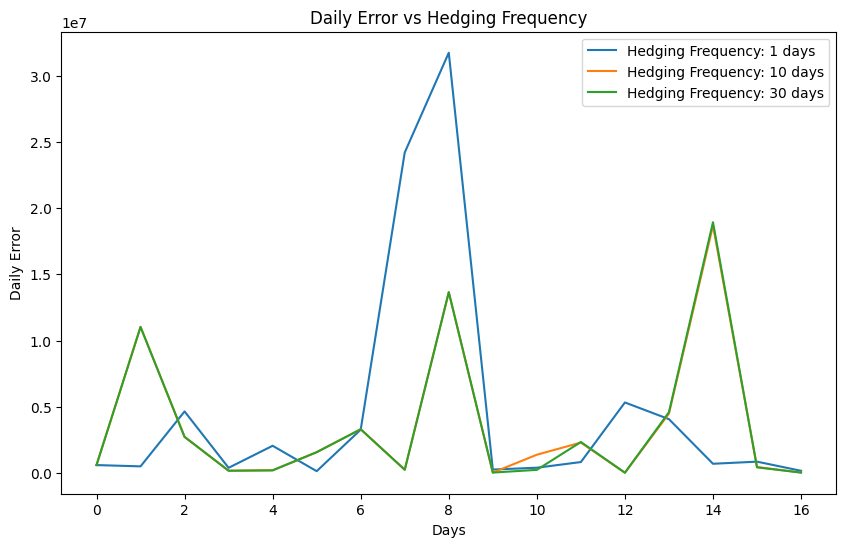

To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 51479
Buy this many Call options:  53430605
Sell this many Put options:  -37096


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 48481
Sell this many Call options:  -136042624
Buy this many Put options:  103410


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 43304
Buy this many Call options:  25616734
Sell this many Put options:  -20004


To adjust portfolio to be delta-vega-gamma neutral, you need to balance your calls and puts the following way: 
Buy this many units of the underlying 37068
Buy this many Call options:  189753903
Sell this many Put options:  -172395


To adjust portfolio to be delta-vega-gamma neutral, you need to bala

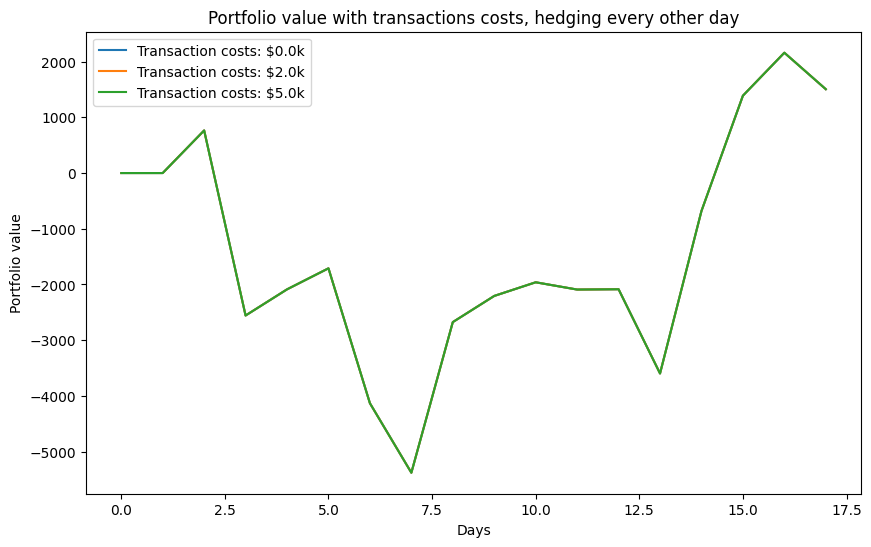

In [83]:
# Hedging frequency in terms of days
freq = 2
total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data = delta_vega_gamma_hedge(df_result, freq, "C225", "P225")

plot_deltas(greek_and_volatility_data)
plot_gammas(greek_and_volatility_data)
plot_vegas(greek_and_volatility_data)
plot_volatilities(greek_and_volatility_data)
plot_total_error_with_frequencies()
plot_daily_error()
plot_portfolio_value()

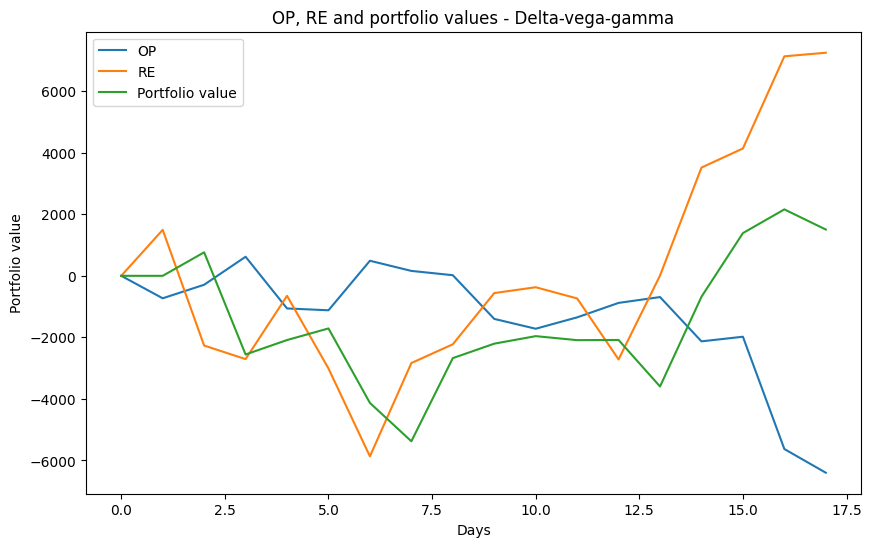

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(OPs, label=f'OP')
plt.plot(REs, label=f'RE')
plt.plot(portfolio_values, label=f'Portfolio value')

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('OP, RE and portfolio values - Delta-vega-gamma')
plt.legend()
plt.show()

## Delta-Gamma хеджирование

In [39]:
def delta_gamma_hedge(option_data, freq, call_column, put_column, costs = 0):
    
    # Initial values at time t = 0
    initial = option_data.iloc[0]
    option_amount = 100
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')
    
    # To make the portfolio Gamma (and Vega) neutral, we have to take both call and put options
    # Gamma expresses how much hedging will cost in a small time interval
    # If Gamma of the portfolio is positive, we make money by delta hedging and vice versa
    # With both Delta and Gamma hedging, we obtain a portfolio, which is even less sensitive to small price changes of the underlying
    # Need to rebalance the hedge for a Delta and Gamma neutral portfolio occurs less often, which saves trading costs
    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    OP = option_amount * call_option_price + option_amount * put_option_price

    # Construct portfolio RE
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    portfolio_values = [OP + RE]
    transaction_costs = 0
    
    column_names = ['call_delta', 'put_delta', 'call_gamma', 'put_gamma','call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                        'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': False}, index=idx)

    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []

    OPs = [OP]
    REs = [RE]
    
    for i in range(1, len(option_data)-1):
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE

        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        OPs.append(new_OP)
        REs.append(new_RE)

        OP = new_OP
        RE = new_RE

        hedge = False
        
        if i % freq == 0:
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)
            
            delta_gamma_coefficients = np.array([
                [call_delta, call_gamma],
                [put_delta, put_gamma]
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta), option_amount * (call_gamma + put_gamma)
            ])
            
            delta_gamma_neutral = np.linalg.solve(delta_gamma_coefficients, right_hand_side)
            print('To make the portfolio delta gamma neutral, you need to adjust the amount of call options: ', round(delta_gamma_neutral[0]))
            print('To make the portfolio delta gamma neutral, you need to adjust the amount of put options: ', round(delta_gamma_neutral[1]))
            print("\n")

            hedge = True

        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_gamma': call_gamma, 'put_gamma': put_gamma,
                   'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        
        new_rows.append(new_row)

    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)

    portfolio_values -= portfolio_values[0]
    REs -= REs[0]
    OPs -= OPs[0]

    return total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data


In [90]:
freq = 1
total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data = delta_gamma_hedge(df_result, freq, "C225", "P225")

To make the portfolio delta gamma neutral, you need to adjust the amount of call options:  15
To make the portfolio delta gamma neutral, you need to adjust the amount of put options:  497


To make the portfolio delta gamma neutral, you need to adjust the amount of call options:  28
To make the portfolio delta gamma neutral, you need to adjust the amount of put options:  728


To make the portfolio delta gamma neutral, you need to adjust the amount of call options:  36
To make the portfolio delta gamma neutral, you need to adjust the amount of put options:  859


To make the portfolio delta gamma neutral, you need to adjust the amount of call options:  30
To make the portfolio delta gamma neutral, you need to adjust the amount of put options:  743


To make the portfolio delta gamma neutral, you need to adjust the amount of call options:  32
To make the portfolio delta gamma neutral, you need to adjust the amount of put options:  753


To make the portfolio delta gamma neutral, you nee

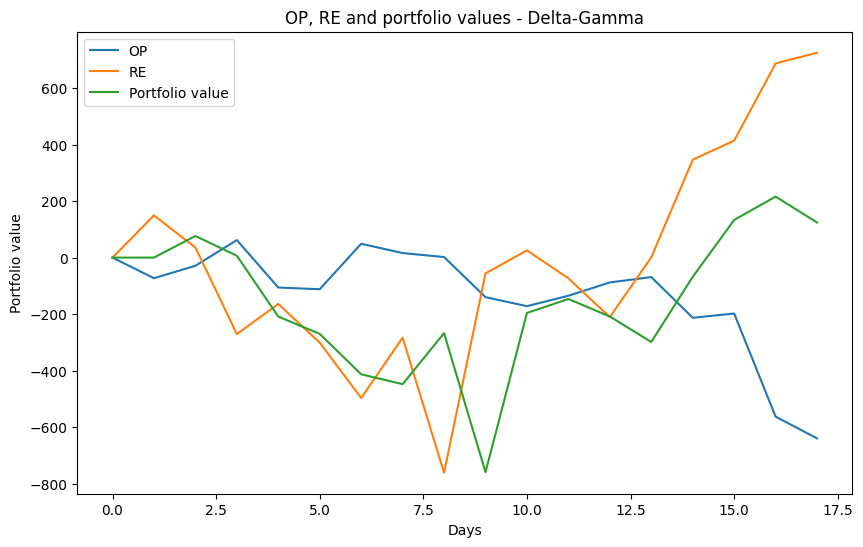

In [91]:

plt.figure(figsize=(10, 6))
plt.plot(OPs, label=f'OP')
plt.plot(REs, label=f'RE')
plt.plot(portfolio_values, label=f'Portfolio value')

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('OP, RE and portfolio values - Delta-Gamma')
plt.legend()
plt.show()

## Delta-Vega хеджирование

In [87]:
def delta_vega_hedge(option_data, freq, call_column, put_column, costs = 0):
    
    # Initial values at time t = 0
    initial = option_data.iloc[0]
    option_amount = 100
    interest_rate = initial['Interest rate']
    stock_price = initial['Underlying']
    call_option_price = initial[call_column]
    put_option_price = initial[put_column]
    call_strike = int(call_column[1:])
    put_strike = int(put_column[1:])
    time_to_maturity = initial['T']
    total_mean_squared_error = []
    
    call_volatility = implied_volatility(price=call_option_price, S=stock_price, K=call_strike, t=time_to_maturity, r=interest_rate, flag='c')
    put_volatility = implied_volatility(price=put_option_price, S=stock_price, K=put_strike, t=time_to_maturity, r=interest_rate, flag='p')


    call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(initial, call_volatility, put_volatility, call_strike, put_strike)

    # Construct portfolio OP, long position
    OP = option_amount * call_option_price + option_amount * put_option_price
    
    # Construct portfolio RE, short position
    # Because delta-vega hedging, hold also amount alpha of the underlying
    # alpha = delta of OP - vega of OP / vega of RE * delta of RE
    # theta = vega of OP / vega of RE
    RE = - call_delta * stock_price * option_amount + put_delta * stock_price * option_amount
    
    portfolio_values = [OP + RE]

    transaction_costs = 0
    
    # Constructing a dataframe for option greeks and implied volatilities, which can then be used later for analysis purposes
    column_names = ['call_delta', 'put_delta', 'call_vega', 'put_vega','call_volatility', 'put_volatility', 'rehedging']
    idx = option_data['Date']

    new_row = pd.DataFrame({'call_delta': call_delta, 'put_delta': put_delta, 'call_vega': call_vega, 'put_vega': put_vega,
                        'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': False}, index=idx)

    greek_and_volatility_data = pd.DataFrame(data = new_row, index = idx, columns=column_names)
    new_rows = []

    OPs = [OP]
    REs = [RE]
    
    for i in range(1, len(option_data)-1):
        hedge = False
        new_OP = option_data[call_column][i] * option_amount + option_data[put_column][i] * option_amount
        new_RE = -call_delta * option_data['Underlying'][i] * option_amount + put_delta * option_data['Underlying'][i] * option_amount
        d_OP = new_OP - OP
        d_RE = new_RE - RE
        
        # In a ideal situation this should be 0 = IMMUNE TO CHANGES
        a_0 = d_OP + d_RE
        total_mean_squared_error.append(a_0**2)
        portfolio_values.append(OP + RE + transaction_costs)

        OPs.append(new_OP)
        REs.append(new_RE)

        OP = new_OP
        RE = new_RE
        
        # Rehedge interval
        # Compute new Deltas, Vegas, and Gammas every time we want to rehedge
        # We need to rehedge, because as time goes by, the price of the underlying changes
        # This affects the option Greeks that measure the market
        if i % freq == 0:
            call_volatility = implied_volatility(price=option_data[call_column][i], S=option_data['Underlying'][i], K=call_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='c')
            put_volatility = implied_volatility(price=option_data[put_column][i], S=option_data['Underlying'][i], K=put_strike, t=option_data['T'][i], r=option_data['Interest rate'][i], flag='p')
            call_delta, call_gamma, call_vega, put_delta, put_gamma, put_vega = get_greeks_for_option(option_data.iloc[i], call_volatility, put_volatility, call_strike, put_strike)

            delta_vega_coefficients = np.array([
                [call_delta, call_vega,],
                [put_delta, put_vega]
            ])

            right_hand_side = np.array([
                option_amount * (call_delta + put_delta), option_amount * (call_vega + put_vega)
            ])
            
            delta_vega_neutral = np.linalg.solve(delta_vega_coefficients, right_hand_side)
            print('To make the portfolio delta vega neutral, you need to adjust the amount of call options: ', round(delta_vega_neutral[0]))
            print('To make the portfolio delta vega neutral, you need to adjust the amount of put options: ', round(delta_vega_neutral[1]))
            print("\n")

            hedge = True

        new_row = {'call_delta': call_delta, 'put_delta': put_delta, 'call_vega': call_vega, 'put_vega': put_vega,
                   'call_volatility': call_volatility, 'put_volatility': put_volatility, 'rehedging': hedge, 'Date': option_data['Date'][i]}
        
        new_rows.append(new_row)

    greek_and_volatility_data = pd.DataFrame(new_rows)
    greek_and_volatility_data.set_index('Date', inplace=True)

    total_error = sum(total_mean_squared_error) - total_mean_squared_error[-1]
    total_error *= (1 / (len(total_mean_squared_error) - 1))
    print("The total mean squared error is : ", total_error)

    portfolio_values -= portfolio_values[0]
    REs -= REs[0]
    OPs -= OPs[0]
    
    return total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data


In [98]:
total_mean_squared_error, total_error, portfolio_values, REs, OPs, greek_and_volatility_data = delta_vega_hedge(df_result, 2, 'C225', 'P225', costs = 0)

To make the portfolio delta vega neutral, you need to adjust the amount of call options:  -5171
To make the portfolio delta vega neutral, you need to adjust the amount of put options:  132


To make the portfolio delta vega neutral, you need to adjust the amount of call options:  -4793
To make the portfolio delta vega neutral, you need to adjust the amount of put options:  134


To make the portfolio delta vega neutral, you need to adjust the amount of call options:  -4453
To make the portfolio delta vega neutral, you need to adjust the amount of put options:  147


To make the portfolio delta vega neutral, you need to adjust the amount of call options:  -3678
To make the portfolio delta vega neutral, you need to adjust the amount of put options:  150


To make the portfolio delta vega neutral, you need to adjust the amount of call options:  -3909
To make the portfolio delta vega neutral, you need to adjust the amount of put options:  129


To make the portfolio delta vega neutral, you

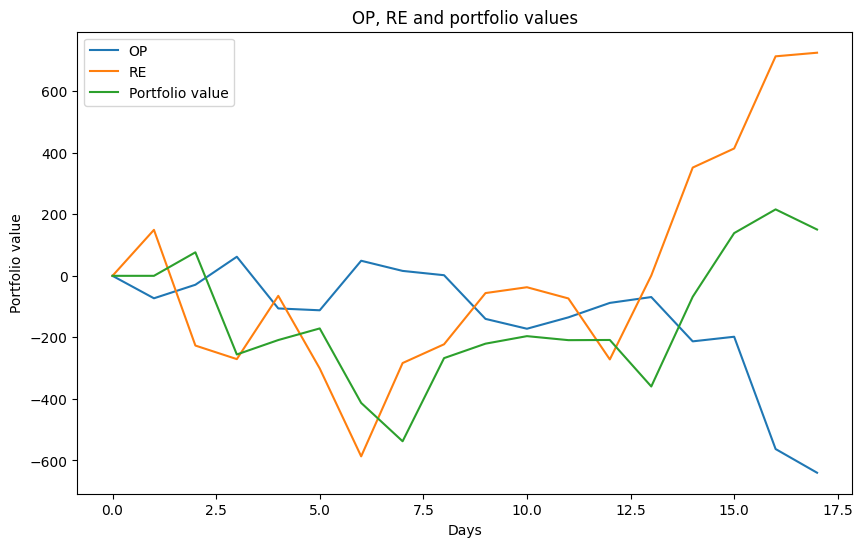

In [99]:
plt.figure(figsize=(10, 6))
plt.plot(OPs, label=f'OP')
plt.plot(REs, label=f'RE')
plt.plot(portfolio_values, label=f'Portfolio value')

plt.xlabel('Days')
plt.ylabel('Portfolio value')
plt.title('OP, RE and portfolio values')
plt.legend()
plt.show()

## Выводы
* Видим, что хеджирование всех греков дает немного лучший результат, чем просто delta хеджирование
* Транзакционные издержви могут быть как больше так и меньше чем при delta хеджировании